In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import plotly.express as px

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [2]:
data= pd.read_csv('Brain_MRI/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [3]:
data2=pd.read_csv('Brain_MRI/data_mask.csv')
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [4]:
brain_scans = []
mask_files = glob.glob('Brain_MRI/*/*_mask*')

for i in mask_files:
    brain_scans.append(i.replace('_mask',''))

print(brain_scans[:10])
print(mask_files[:10])

['Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_19.tif']
['Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11_mask.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12_mask.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13_mask.tif', 'Brain_MRI\\TCGA_CS_4941_19960909\\TCGA_CS_4941_199609

In [6]:
# Create a comprehensive dataframe with brain scan images and their corresponding masks
data_img = pd.DataFrame({
    "image_path": brain_scans,
    "mask_path": mask_files
})

# Add additional metadata columns for better data management
data_img['image_name'] = data_img['image_path'].apply(lambda x: x.split('/')[-1])
data_img['mask_name'] = data_img['mask_path'].apply(lambda x: x.split('/')[-1])
data_img['patient_id'] = data_img['image_name'].apply(lambda x: x.split('_')[0])

In [7]:
# Function to detect tumor presence by analyzing mask pixel values
# Returns 1 if tumor is present (max pixel value > 0), 0 if no tumor detected
def detect_tumor_presence(mask_file_path):
    """
    Analyze mask image to determine tumor presence.
    
    Args:
        mask_file_path (str): Path to the mask image file
        
    Returns:
        int: 1 if tumor present, 0 if no tumor
    """
    try:
        # Load mask image in grayscale mode for better performance
        mask = cv2.imread(mask_file_path, cv2.IMREAD_GRAYSCALE)
        
        # Handle case where image couldn't be loaded
        if mask is None:
            print(f"Warning: Could not load mask file {mask_file_path}")
            return 0
            
        # Check if any pixel value indicates tumor presence
        max_pixel_value = np.max(mask)
        return 1 if max_pixel_value > 0 else 0
        
    except Exception as e:
        print(f"Error processing {mask_file_path}: {str(e)}")
        return 0

# Create tumor diagnosis column by applying the detection function to all mask paths
print("Analyzing masks for tumor presence...")
data_img["tumor_present"] = data_img["mask_path"].apply(detect_tumor_presence)

# Display summary statistics
tumor_count = data_img["tumor_present"].sum()
total_images = len(data_img)
print(f"Tumor detection complete:")
print(f"- Total images analyzed: {total_images}")
print(f"- Images with tumors: {tumor_count}")
print(f"- Images without tumors: {total_images - tumor_count}")
print(f"- Tumor prevalence: {tumor_count/total_images:.2%}")

Analyzing masks for tumor presence...
Tumor detection complete:
- Total images analyzed: 3929
- Images with tumors: 1373
- Images without tumors: 2556
- Tumor prevalence: 34.95%


In [8]:
# How many non-tumors (0) and tumors (1) are in the data
data_img['tumor_present'].value_counts()

tumor_present
0    2556
1    1373
Name: count, dtype: int64

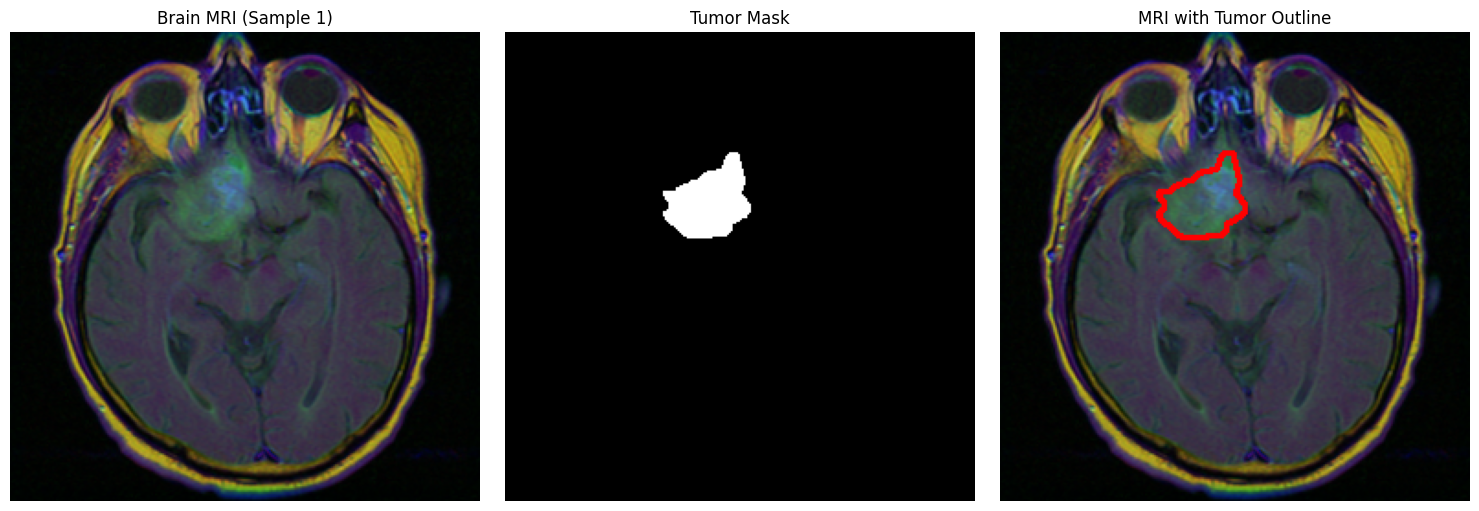

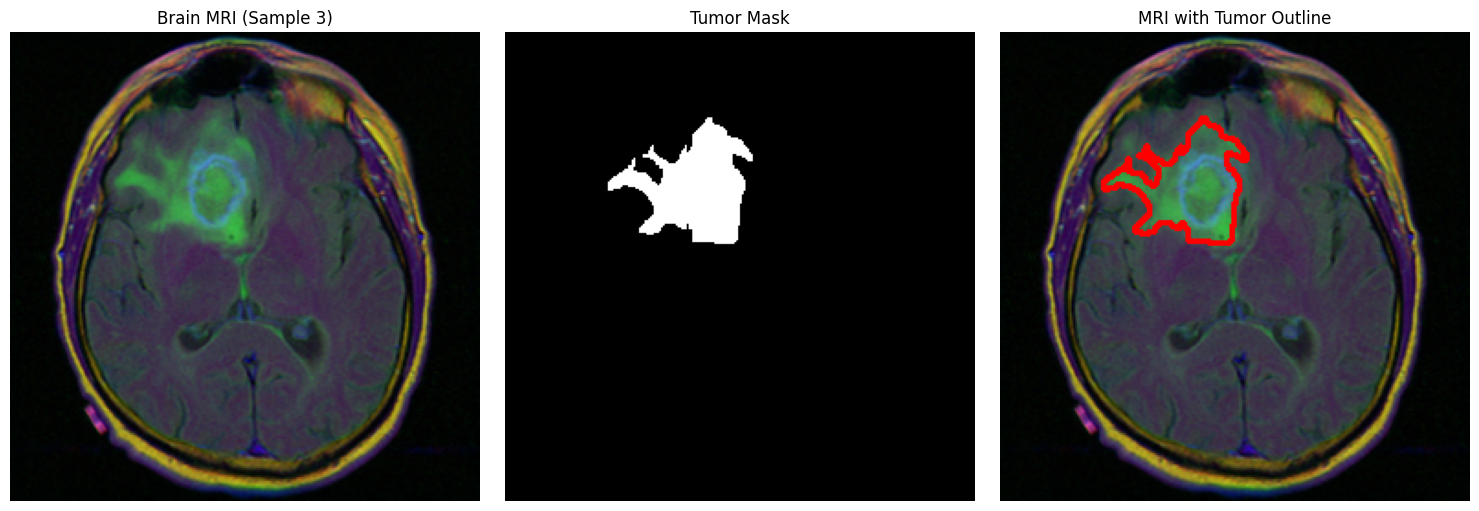

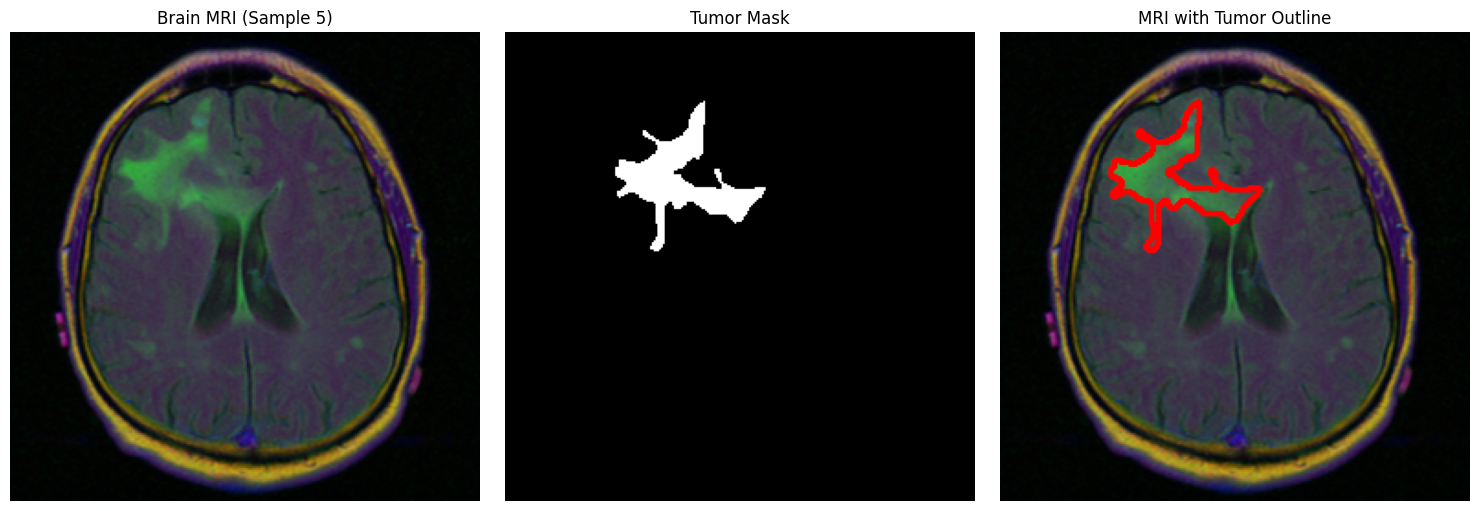

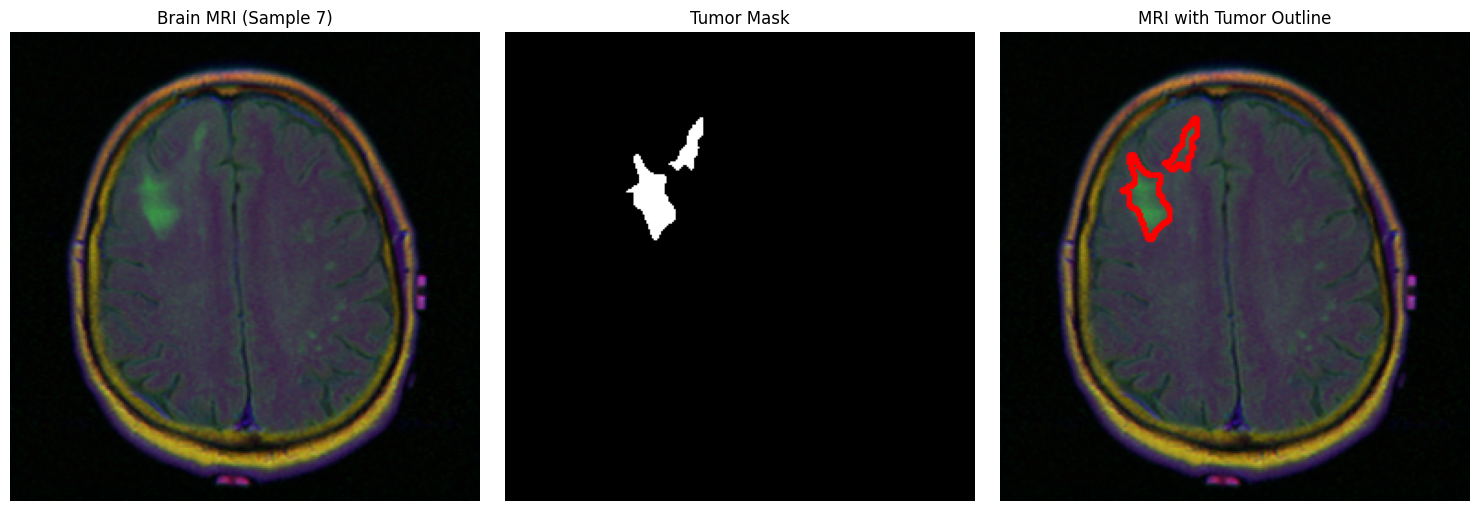

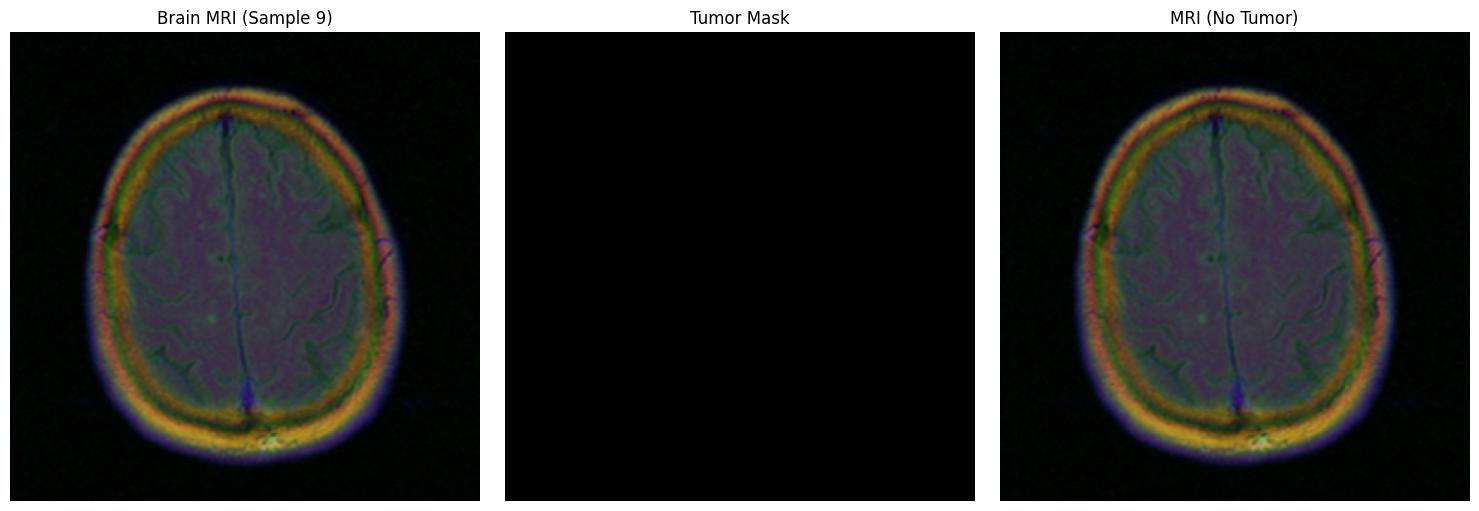

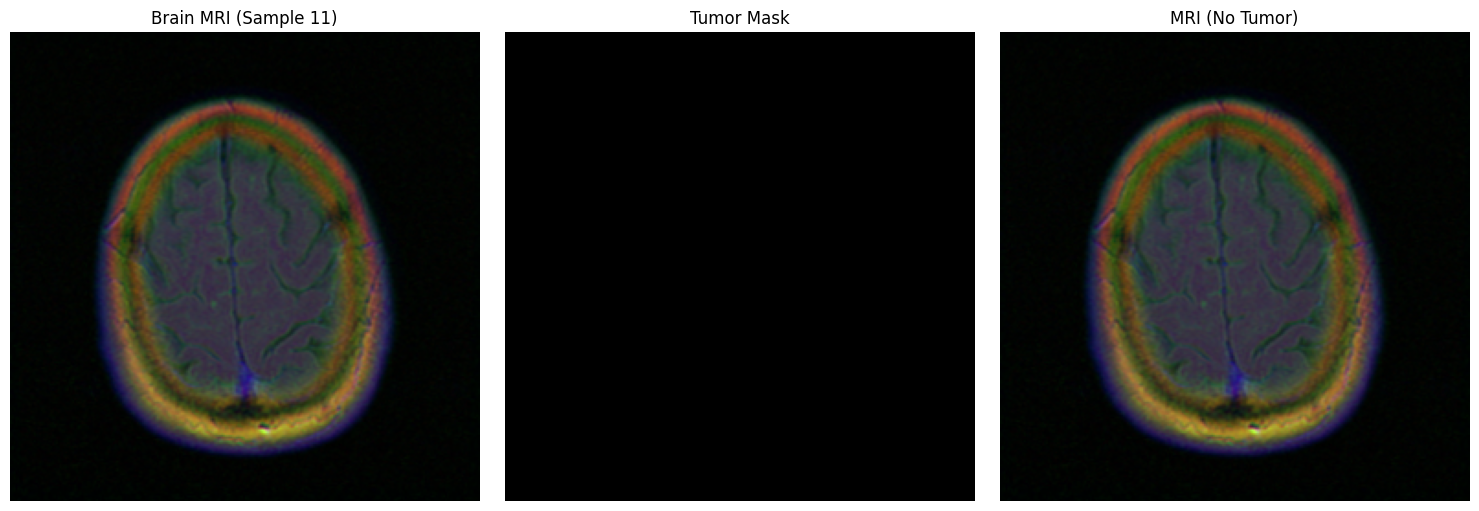

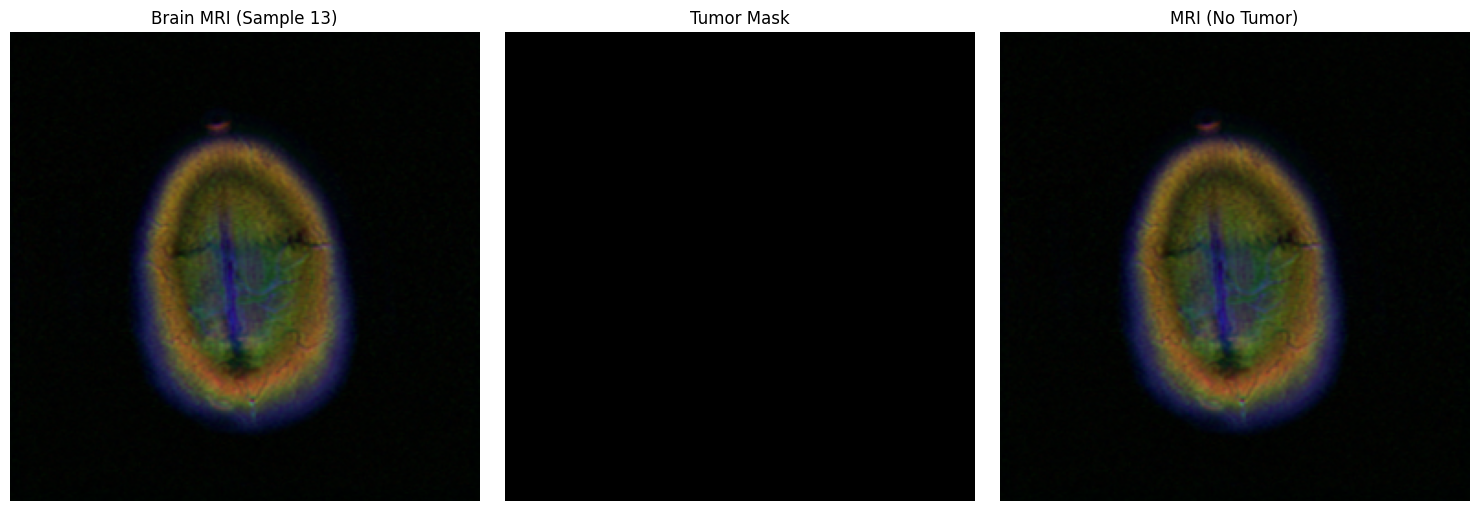

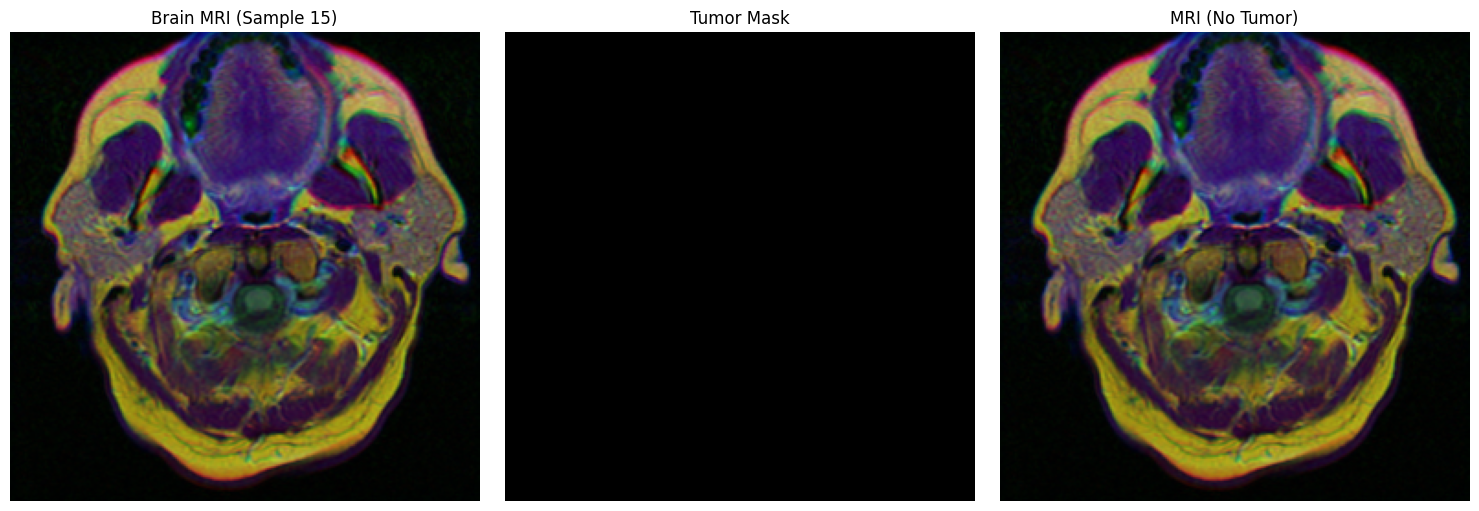

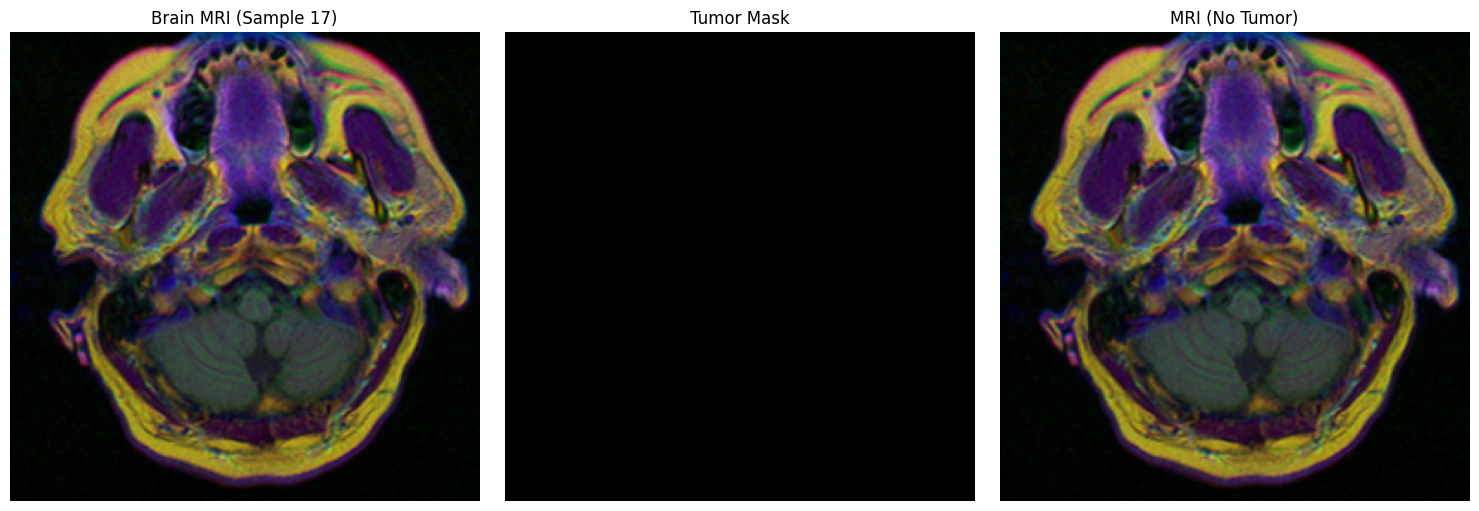

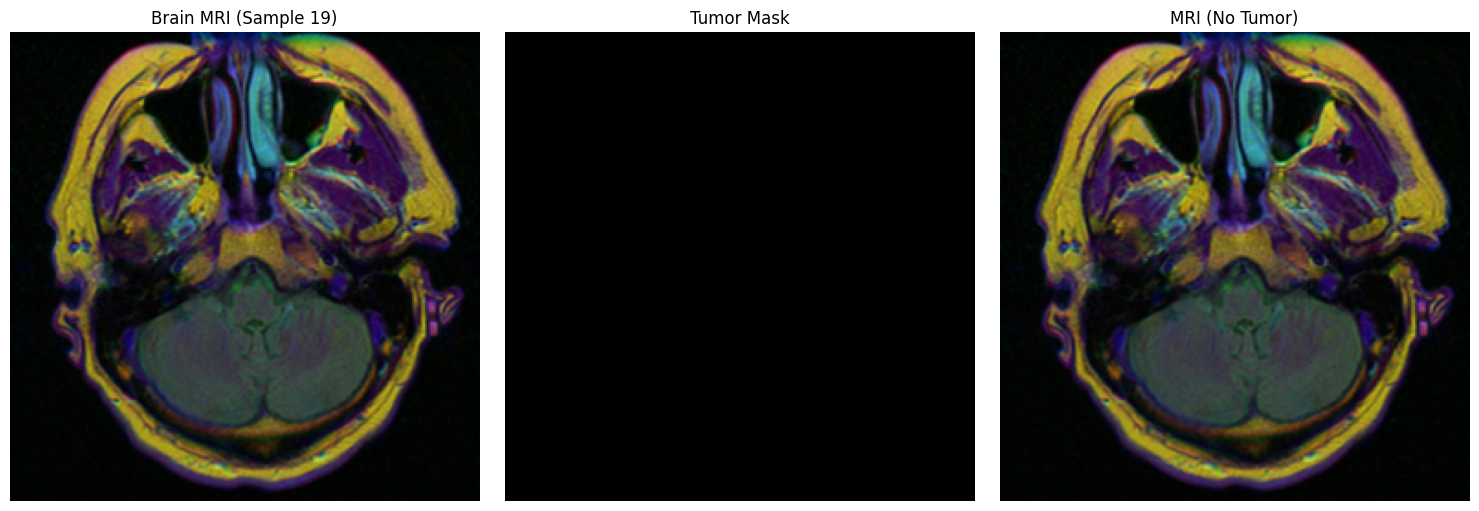

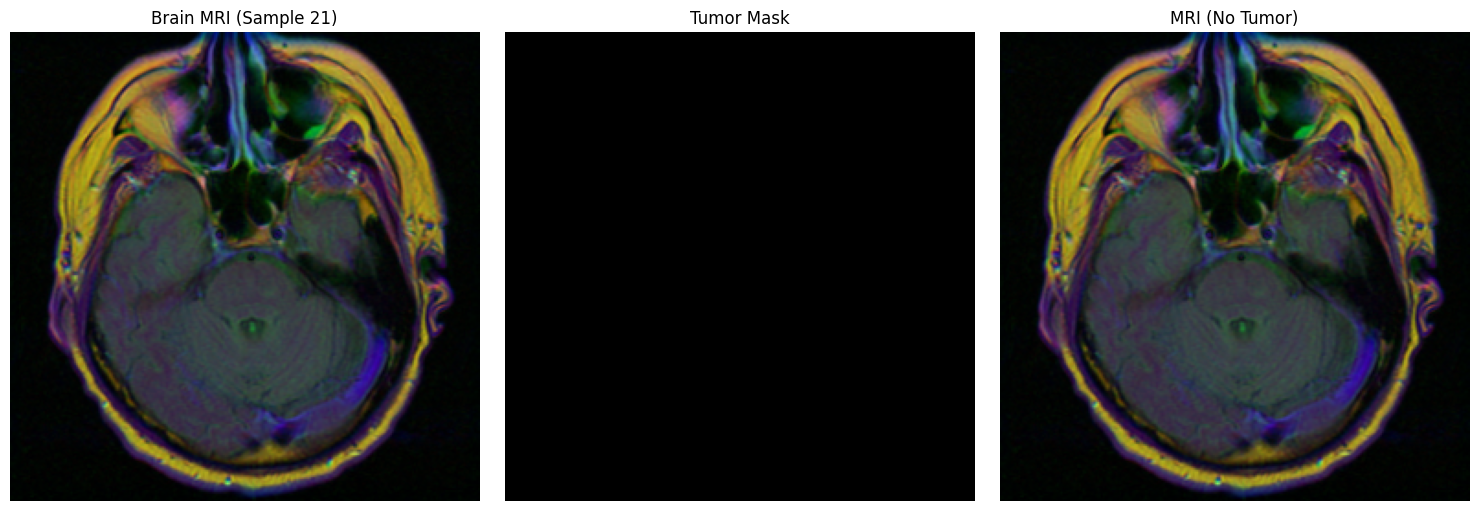

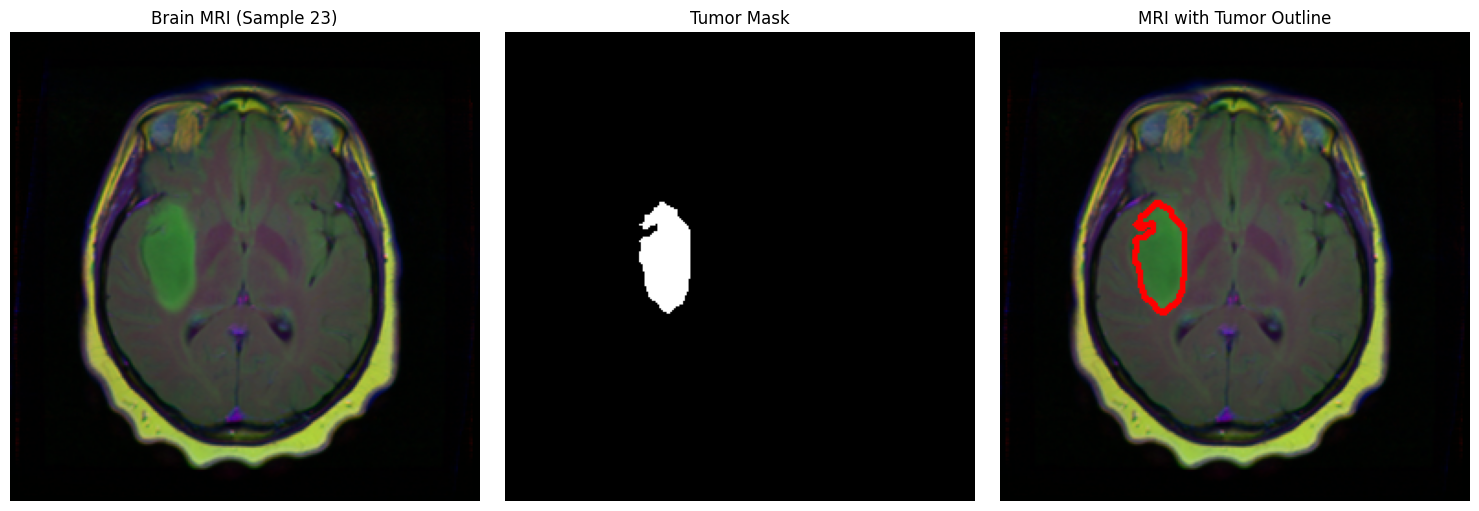

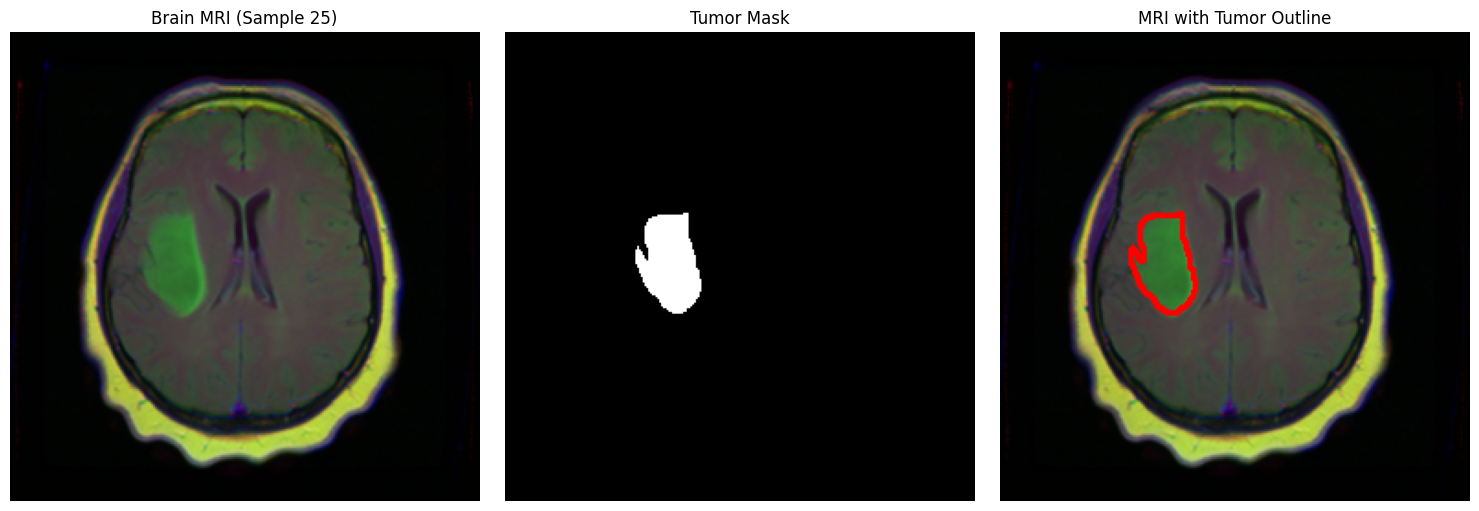

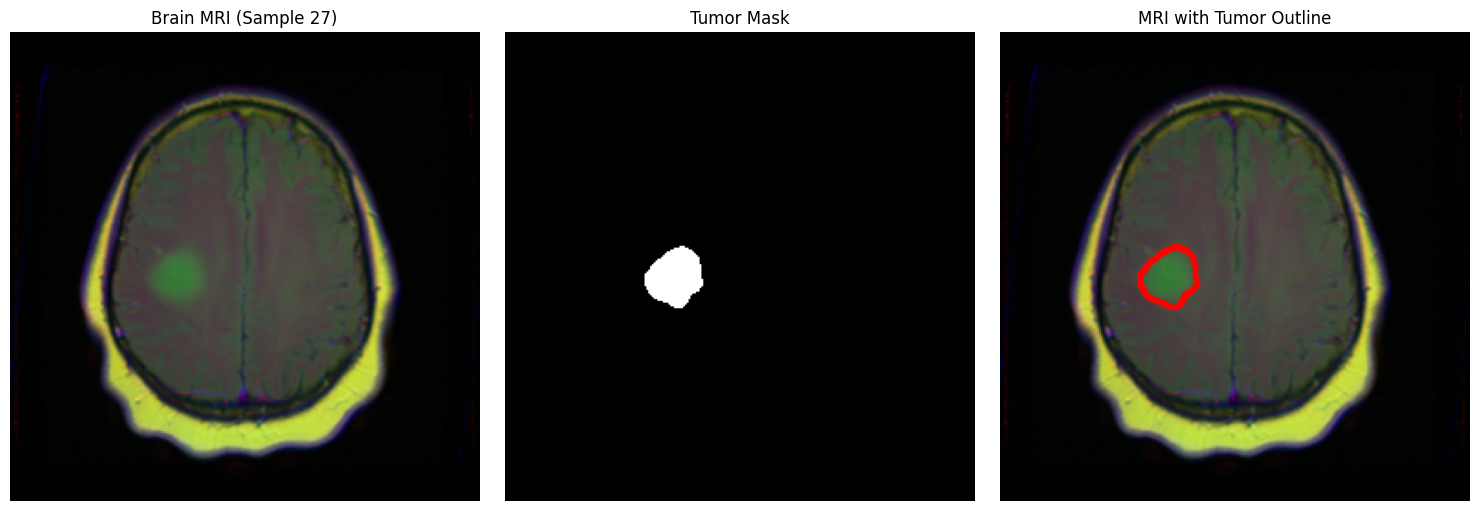

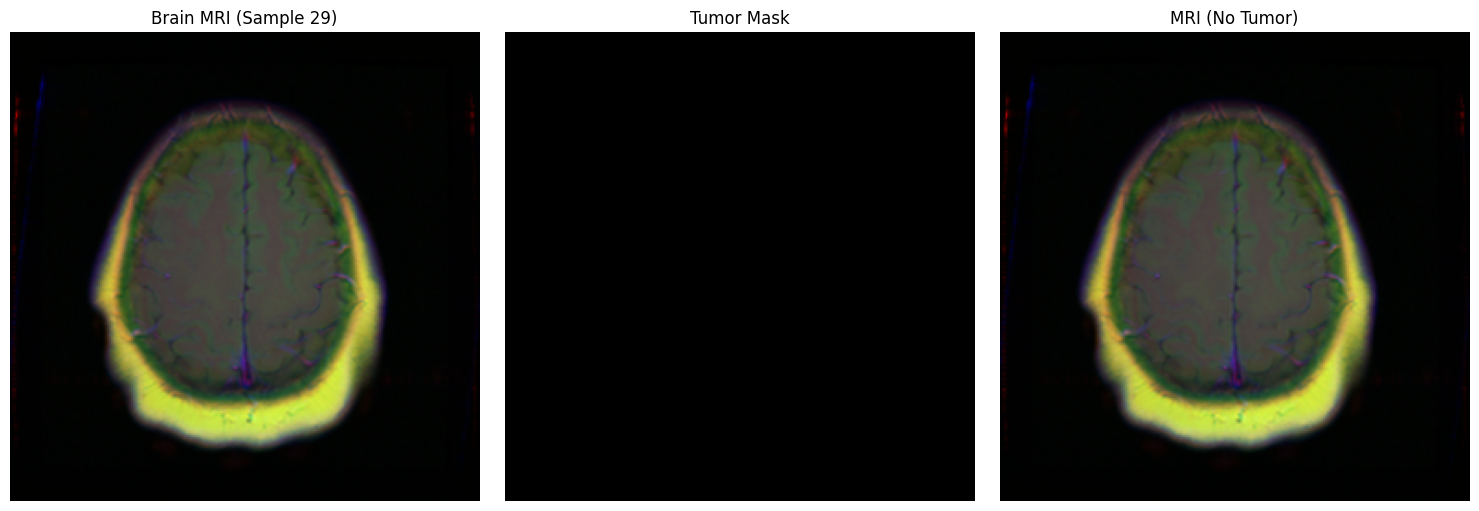

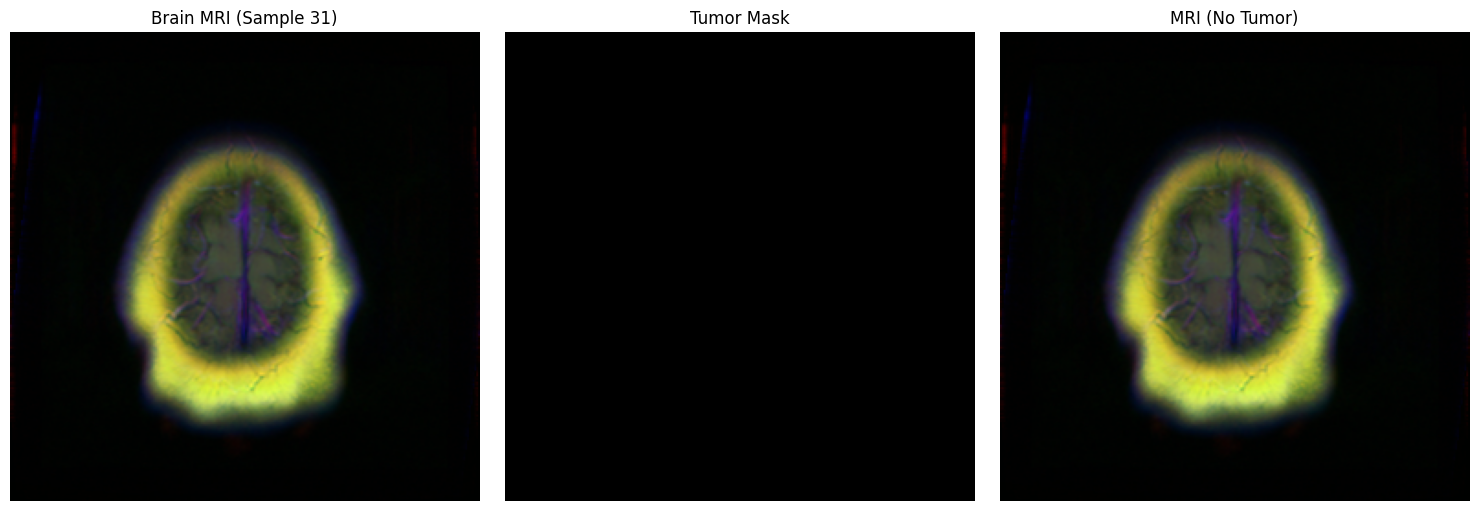

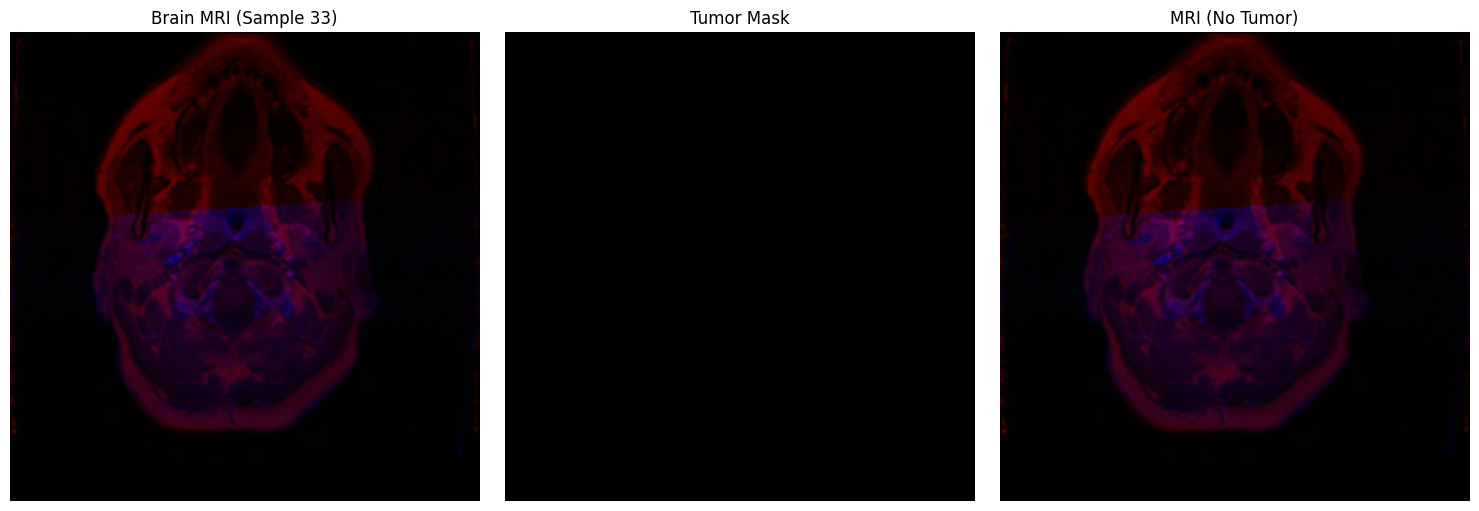

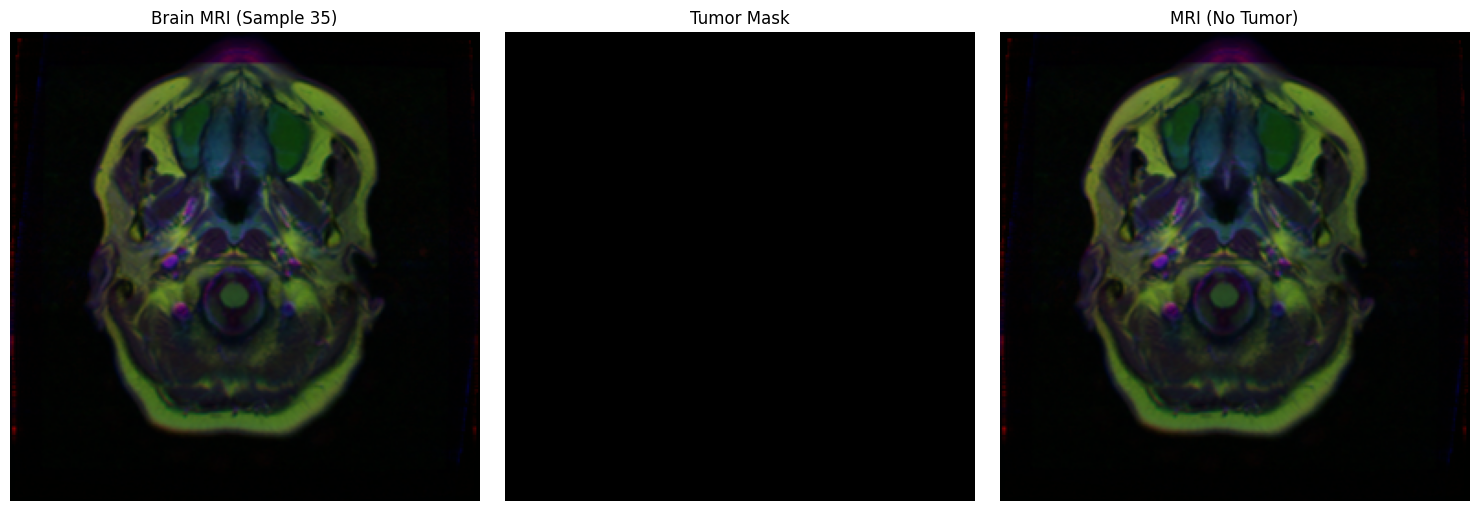

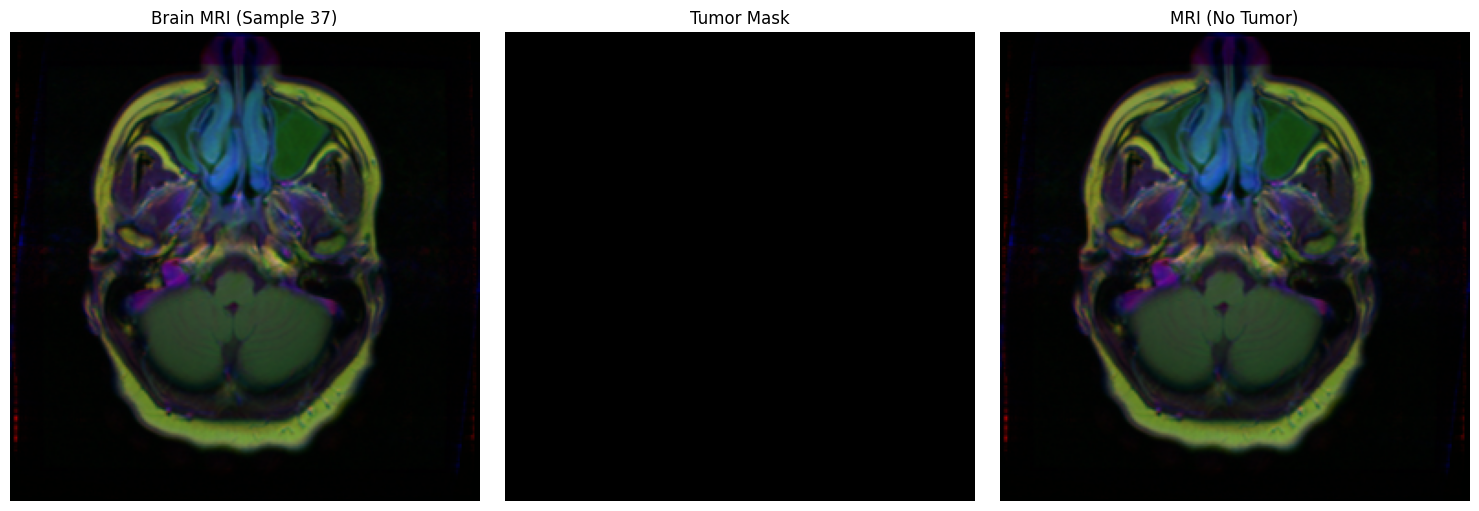

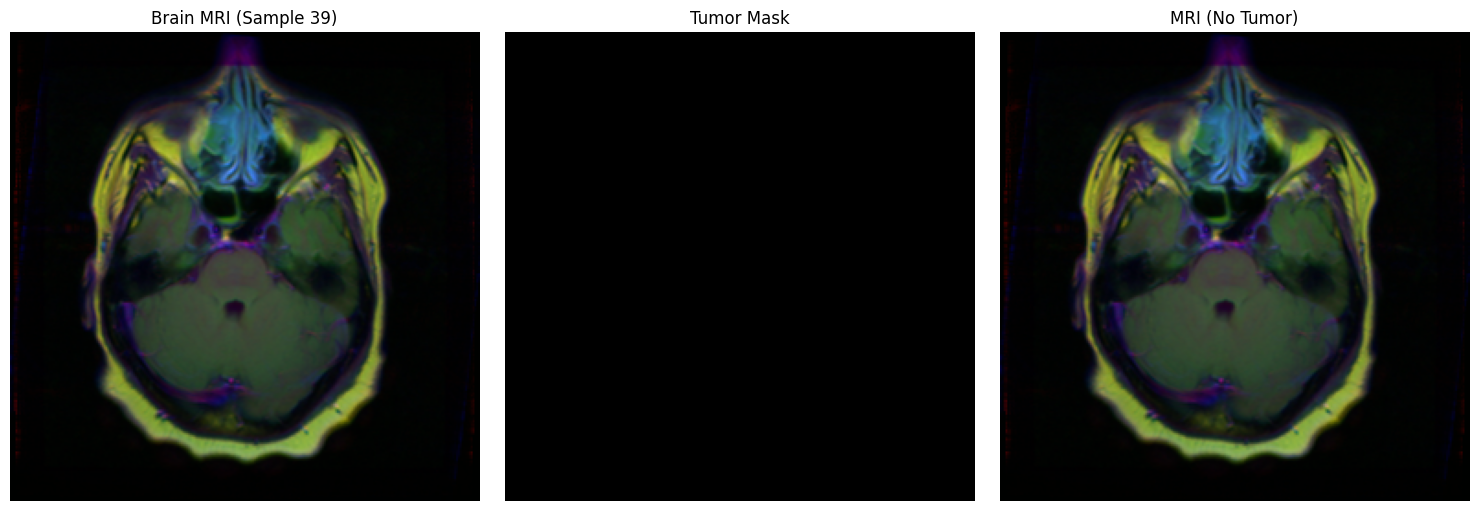

In [9]:
# Visualize sample brain MRI scans with their corresponding masks
for i in range(1, 40, 2):
    # Get image and mask paths from the dataframe
    img_path = data_img.iloc[i]['image_path']
    msk_path = data_img.iloc[i]['mask_path']
    
    # Load and process the brain MRI image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    msk = cv2.imread(msk_path)

    # Create subplot for visualization
    original = img.copy()
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot the original Brain MRI scan
    ax[0].imshow(original)
    ax[0].set_title(f"Brain MRI (Sample {i})")
    ax[0].axis('off')
   
    # Plot the corresponding tumor mask
    mask = msk.copy()
    ax[1].imshow(mask)
    ax[1].set_title("Tumor Mask")
    ax[1].axis('off')

    # Plot the Brain MRI scan with tumor overlay
    main = original.copy()
    label = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
    
    # Only process if mask contains tumor (non-zero pixels)
    if np.max(label) > 0:
        contours, hier = cv2.findContours(label, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        sample_over_gt = cv2.drawContours(main, contours, -1, [255, 0, 0], thickness=2)
        ax[2].imshow(sample_over_gt)
        ax[2].set_title("MRI with Tumor Outline")
    else:
        ax[2].imshow(main)
        ax[2].set_title("MRI (No Tumor)")
    
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [10]:
# Convert the tumor_present column to string format for categorical classification
data_img['tumor_present'] = data_img['tumor_present'].apply(lambda x: str(x))
data_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_path     3929 non-null   object
 1   mask_path      3929 non-null   object
 2   image_name     3929 non-null   object
 3   mask_name      3929 non-null   object
 4   patient_id     3929 non-null   object
 5   tumor_present  3929 non-null   object
dtypes: object(6)
memory usage: 184.3+ KB


In [11]:
from sklearn.model_selection import train_test_split

# Split the brain MRI dataset into train, validation, and test sets
# Using stratified split to maintain class balance across splits
train, test = train_test_split(data_img, test_size=0.1, random_state=42, stratify=data_img['tumor_present'])
train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train['tumor_present'])

print(f"Training set shape: {train.shape}")
print(f"Validation set shape: {val.shape}")
print(f"Test set shape: {test.shape}")

# Display class distribution in each split
print("\nClass distribution:")
print("Training set:")
print(train['tumor_present'].value_counts())
print("\nValidation set:")
print(val['tumor_present'].value_counts())
print("\nTest set:")
print(test['tumor_present'].value_counts())

print("\nTraining set sample:")
print(train.head())
print("\nValidation set sample:")
print(val.head())

Training set shape: (2828, 6)
Validation set shape: (708, 6)
Test set shape: (393, 6)

Class distribution:
Training set:
tumor_present
0    1839
1     989
Name: count, dtype: int64

Validation set:
tumor_present
0    461
1    247
Name: count, dtype: int64

Test set:
tumor_present
0    256
1    137
Name: count, dtype: int64

Training set sample:
                                             image_path  \
795   Brain_MRI\TCGA_DU_6400_19830518\TCGA_DU_6400_1...   
1547  Brain_MRI\TCGA_DU_7301_19911112\TCGA_DU_7301_1...   
221   Brain_MRI\TCGA_CS_6290_20000917\TCGA_CS_6290_2...   
2081  Brain_MRI\TCGA_DU_A5TS_19970726\TCGA_DU_A5TS_1...   
3836  Brain_MRI\TCGA_HT_A61A_20000127\TCGA_HT_A61A_2...   

                                              mask_path  \
795   Brain_MRI\TCGA_DU_6400_19830518\TCGA_DU_6400_1...   
1547  Brain_MRI\TCGA_DU_7301_19911112\TCGA_DU_7301_1...   
221   Brain_MRI\TCGA_CS_6290_20000917\TCGA_CS_6290_2...   
2081  Brain_MRI\TCGA_DU_A5TS_19970726\TCGA_DU_A5TS_1...   
383

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

# Data preprocessing and augmentation for brain MRI images
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess brain MRI images for model training
    """
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize image
    img = cv2.resize(img, target_size)
    
    # Normalize pixel values
    img = img.astype('float32') / 255.0
    
    # Add channel dimension for grayscale
    img = np.expand_dims(img, axis=-1)
    
    return img

# Create data generators for brain MRI classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Build CNN model for brain tumor detection
def create_brain_tumor_model(input_shape=(224, 224, 1)):
    """
    Create a CNN model for brain tumor classification
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification: tumor present (1) or not (0)
    ])
    
    return model

# Create and compile the model
model = create_brain_tumor_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Brain Tumor Detection Model Architecture:")
model.summary()

# Define callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
]

print(f"\nDataset splits for brain MRI classification:")
print(f"Training samples: {len(train)} (Tumor: {train['tumor_present'].value_counts()['1']}, No Tumor: {train['tumor_present'].value_counts()['0']})")
print(f"Validation samples: {len(val)} (Tumor: {val['tumor_present'].value_counts()['1']}, No Tumor: {val['tumor_present'].value_counts()['0']})")
print(f"Test samples: {len(test)} (Tumor: {test['tumor_present'].value_counts()['1']}, No Tumor: {test['tumor_present'].value_counts()['0']})")

c:\Users\miraz\OneDrive\Documents\GitHub\-End-to-End-Deep-Learning-for-Pediatric-Glioma-Classification\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Brain Tumor Detection Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,396,225 (73.99 MB)

 Trainable params: 19,395,265 (73.99 MB)

 Non-trainable params: 960 (3.75 KB)


Dataset splits for brain MRI classification:
Training samples: 2828 (Tumor: 989, No Tumor: 1839)
Validation samples: 708 (Tumor: 247, No Tumor: 461)
Test samples: 393 (Tumor: 137, No Tumor: 256)


In [13]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import map_coordinates


def elastic_transform(image, alpha_range, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       
   # Arguments
       image: Numpy array with shape (height, width, channels). 
       alpha_range: Float for fixed value or [lower, upper] for random value from uniform distribution.
           Controls intensity of deformation.
       sigma: Float, sigma of gaussian filter that smooths the displacement fields.
       random_state: `numpy.random.RandomState` object for generating displacement fields.
    """
    
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))
    
    transformed_images = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

    return transformed_images

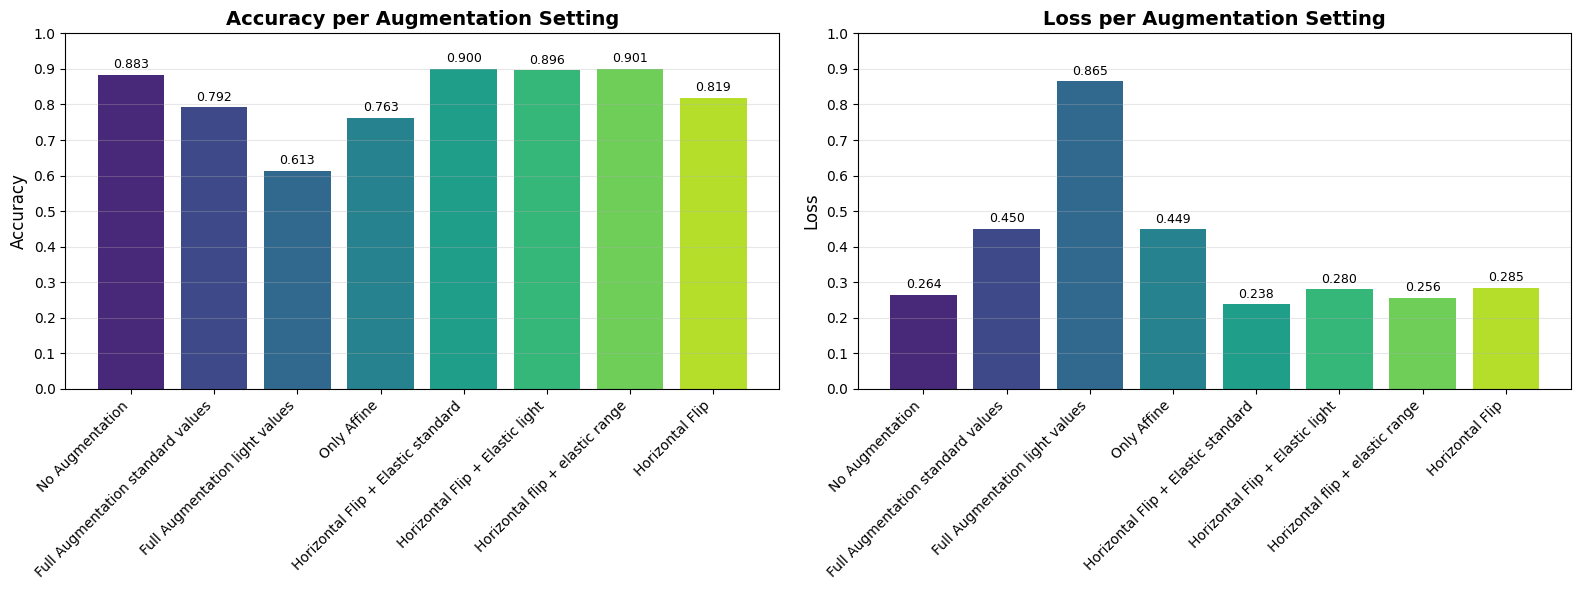

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Create figure with subplots for better visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracies: ###########################
accuracy_values = [0.8830, 0.7917, 0.6132, 0.7631, 0.9005, 0.8957, 0.9008, 0.8193]
augmentation_methods = ('No Augmentation', 'Full Augmentation standard values', 'Full Augmentation light values', 'Only Affine',
        'Horizontal Flip + Elastic standard', 'Horizontal Flip + Elastic light', 'Horizontal flip + elastic range',
        'Horizontal Flip'
       )

x_pos = np.arange(len(augmentation_methods))
colours = sns.color_palette("viridis", 8)

# Create accuracy bars
bars1 = ax1.bar(x_pos, accuracy_values, color=colours)
ax1.set_title('Accuracy per Augmentation Setting', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim(0, 1.0)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.set_xticks(x_pos)
ax1.set_xticklabels(augmentation_methods, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars1, accuracy_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# Losses #########################
loss_values = [0.2641, 0.4504, 0.8652, 0.4492, 0.2381, 0.2797, 0.2563, 0.2848]

# Create loss bars
bars2 = ax2.bar(x_pos, loss_values, color=colours)
ax2.set_title('Loss per Augmentation Setting', fontsize=14, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_ylim(0, 1.0)
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_xticks(x_pos)
ax2.set_xticklabels(augmentation_methods, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars2, loss_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rescale=1./255., 
                             validation_split=0.15,
                             horizontal_flip = True,
                            # zoom_range = ,
                            # width_shift_range= ,
                            # height_shift_range= ,
                             preprocessing_function = lambda x: elastic_transform(x, 
                                                                                 alpha_range =  [2,6],
                                                                                 sigma = 2.5)
                            )
                            

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='tumor_present',
                                              subset='training',
                                              class_mode='binary',
                                              batch_size=32,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )

valid_generator = datagen.flow_from_dataframe(val,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='tumor_present',
                                              subset='validation',
                                              class_mode='binary',
                                              batch_size=32,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='tumor_present',
                                                  class_mode='binary',
                                                  batch_size=32,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 2404 validated image filenames belonging to 2 classes.
Found 106 validated image filenames belonging to 2 classes.
Found 393 validated image filenames belonging to 2 classes.


In [17]:
# Taking a pretrained base
from tensorflow.keras.applications import VGG16

pretrained_base = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(256,256,3)))
pretrained_base.summary()  

# The pretrained base not trainable.
pretrained_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras import layers

model = keras.Sequential([
    
    # Base
    pretrained_base,
    
    # Head
    layers.GlobalAveragePooling2D(name='GlobalAvgPool'),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.BatchNormalization(name='batch_norm_1'),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(256, activation='relu', name='dense_2'),
    layers.BatchNormalization(name='batch_norm_2'),
    layers.Dropout(0.3, name='dropout_2'),
    layers.Dense(1, activation='sigmoid', name='output'),
])

In [19]:
# Compile the model with appropriate loss function and optimizer for binary classification
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', 'precision', 'recall']
)

# Display model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalAvgPool                   │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [21]:
# Import required callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Define callbacks for training optimization
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              mode='min', 
                              verbose=1, 
                              patience=15,  # Reduced patience for faster training
                              restore_best_weights=True
                             )

checkpointer = ModelCheckpoint(filepath="pediatric_glioma_vgg16_model.h5",
                               monitor='val_accuracy',
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=False
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,  # Reduced patience for more responsive learning rate adjustment
                              min_delta=0.0001,
                              factor=0.3,  # Less aggressive reduction
                              min_lr=1e-7
                             )

# Additional callback for better monitoring
tensorboard = TensorBoard(log_dir='./logs', 
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True)

callbacks = [checkpointer, earlystopping, reduce_lr, tensorboard]

In [ ]:
# Train the model with optimized parameters for pediatric glioma classification
history = model.fit(
    train_generator, 
    steps_per_epoch=train_generator.n // train_generator.batch_size, 
    epochs=50,  # Reduced epochs for faster training while maintaining effectiveness
    validation_data=valid_generator, 
    validation_steps=valid_generator.n // valid_generator.batch_size,
    callbacks=callbacks,
    verbose=1,  # Show progress during training
    shuffle=True  # Shuffle training data for better generalization
)